Sources:
- https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/
- https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [1]:
import pandas as pd

df = pd.read_csv('data/creditcard_fraud_dataset.csv')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

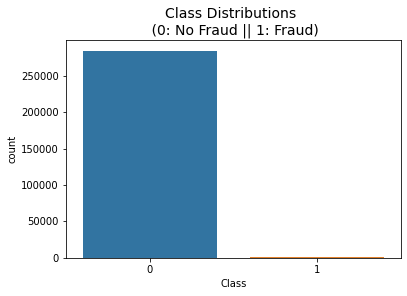

In [3]:
sns.countplot(x='Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

## Data preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

## Cost matrix

Remember the **confusion matrix** of a binary classifier:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | TN              | FN              |
| Predicted Positive | FP              | TP              |


In many applications, the cost of false positive predictions is not the same as the cost of false negative predictions. We can try to assign a cost to each cell of the confusion matrix. As such, we obtain the **cost matrix**:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | $C_{TN}$        | $C_{FN}$        |
| Predicted Positive | $C_{FP}$        | $C_{TP}$        |

Often, $C_{TN} = C_{TP} = 0$, so this reduces to:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | $0$             | $C_{FN}$        |
| Predicted Positive | $C_{FP}$        | $0$             |

We can define the total cost of a classifier using this framework as the **cost-weighted sum of the False Negatives and False Positives**:

$$
\text{Total Cost} = C_{FN} \cdot \text{FN} + C_{FP} \cdot \text{FP}
$$

This is the value that we seek to minimize in cost-sensitive learning.

In [5]:
C_FP = 5
df['C_FP'] = C_FP
df['C_FN'] = df['Amount']

In [6]:
from sklearn.model_selection import train_test_split

X = df[[*[f'V{i}' for i in range(1, 29)], 'scaled_amount', 'scaled_time']]
y = df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=42)

df_train = df.loc[X_train.index]
df_test = df.loc[X_test.index]

In [7]:
import numpy as np

one_hot_classes = np.zeros((len(Y_train), 2))
one_hot_classes[np.arange(len(Y_train)), Y_train.values] = 1

costs = df_train[['C_FP', 'C_FN']].values
sample_weight = np.multiply(costs, one_hot_classes).sum(axis=1)

In [8]:
from sklearn.linear_model import LogisticRegression
from itertools import product
from tqdm import tqdm

MAX_ITER = 200
RANDOM_STATE = 42

clfs = {}

for cw, sw in tqdm(list(product(['balanced', None],
                                [sample_weight, None]))):
    name = (
        f"Class {'un' if cw is None else ''}balanced, "
        f"Sample {'un' if sw is None else ''}weighted"
    )
    clfs[name] = LogisticRegression(
        class_weight=cw,
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE,
    ).fit(
        X_train,
        Y_train,
        sample_weight=sw
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.48s/it]


# Evaluation

We compute the percentage of the sum of the amounts of all fraudulent transactions that the model saved by correctly detecting fraud.

In [9]:
def eval_fraud_perc(amounts, y_true, y_pred):
    total_fraud = (amounts * y_true).sum()
    total_tp_fraud = (amounts * y_true * y_pred).sum()
    return total_tp_fraud, total_fraud, total_tp_fraud / total_fraud

In [10]:
from sklearn.metrics import precision_score, recall_score


def evaluate_y_pred(y_pred):
    y_true = df_test['Class']
    amounts = df_test['Amount']
    total_tp_fraud, total_fraud, tot_fraud_perc = eval_fraud_perc(amounts, y_true, y_pred)
    tps = (y_true * y_pred).sum()
    fps = y_pred.sum() - tps

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)

    fp_loss = C_FP*fps
    net_loss = fp_loss + total_fraud - total_tp_fraud

    print('-'*100)
    print(f'Precision {p*100:.2f}%')
    print(f'Recall {r*100:.2f}%')
    print()
    print(f'€{total_tp_fraud:,.2f} of €{total_fraud:,.2f} fraudulent transactions detected ({tot_fraud_perc*100:.2f}%)')
    print(f'€{fp_loss:,.2f} cost due to {fps:,} transactions erroneously marked as fraudulent')
    print(f'€{net_loss:,.2f} net loss')
    print('-'*100)
    print()


def evaluate_clf_preds(clf_preds):
    for name, y_pred in clf_preds.items():
        print('-'*100)
        print(f'** {name.title()} **')
        evaluate_y_pred(y_pred)

In [11]:
clf_preds = {
    name: clf.predict(
        X_test
    )
    for name, clf in clfs.items()
}

In [12]:
evaluate_clf_preds(clf_preds)

----------------------------------------------------------------------------------------------------
** Class Balanced, Sample Weighted **
----------------------------------------------------------------------------------------------------
Precision 1.43%
Recall 92.68%

€30,249.12 of €31,256.57 fraudulent transactions detected (96.78%)
€78,730.00 cost due to 15,746 transactions erroneously marked as fraudulent
€79,737.45 net loss
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
** Class Balanced, Sample Unweighted **
----------------------------------------------------------------------------------------------------
Precision 6.42%
Recall 88.21%

€27,675.81 of €31,256.57 fraudulent transactions detected (88.54%)
€15,820.00 cost due to 3,164 transactions erroneously marked as fraudulent
€19,400.76 net loss
-----------------------------

# Balance dataset by subsampling

In [13]:
neg_mask = Y_train == 0
pos_mask = Y_train == 1

n_pos = pos_mask.sum()
neg_idxs = df_train[neg_mask].sample(n=n_pos, random_state=RANDOM_STATE).index
pos_idxs = df_train[pos_mask].index

In [14]:
X_train_sub = pd.concat([X_train.loc[neg_idxs],
                         X_train.loc[pos_idxs]])
Y_train_sub = pd.concat([Y_train.loc[neg_idxs],
                         Y_train.loc[pos_idxs]])
df_train_sub = pd.concat([df_train.loc[neg_idxs],
                          df_train.loc[pos_idxs]])

In [15]:
one_hot_classes_sub = np.zeros((len(Y_train_sub), 2))
one_hot_classes_sub[
    np.arange(len(Y_train_sub)),
    Y_train_sub.values
] = 1
costs_sub = df_train_sub[['C_FP', 'C_FN']].values
sample_weight_sub = np.multiply(costs_sub, one_hot_classes_sub).sum(axis=1)

In [16]:
clfs_sub = {}

for sw in tqdm([sample_weight_sub, None]):
    name = (
        f"Subsampled, "
        f"Sample {'un' if sw is None else ''}weighted"
    )
    clfs_sub[name] = LogisticRegression(
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE,
    ).fit(
        X_train_sub,
        Y_train_sub,
        sample_weight=sw
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.19it/s]


In [17]:
clf_preds_sub = {
    name: clf.predict(
        X_test
    )
    for name, clf in clfs_sub.items()
}

In [18]:
evaluate_clf_preds(clf_preds_sub)

----------------------------------------------------------------------------------------------------
** Subsampled, Sample Weighted **
----------------------------------------------------------------------------------------------------
Precision 1.18%
Recall 92.68%

€29,945.13 of €31,256.57 fraudulent transactions detected (95.80%)
€95,275.00 cost due to 19,055 transactions erroneously marked as fraudulent
€96,586.44 net loss
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
** Subsampled, Sample Unweighted **
----------------------------------------------------------------------------------------------------
Precision 4.18%
Recall 90.24%

€28,685.72 of €31,256.57 fraudulent transactions detected (91.78%)
€25,440.00 cost due to 5,088 transactions erroneously marked as fraudulent
€28,010.85 net loss
-------------------------------------

# Using cost-sensitive threshold

Only classify $P_{+}$ as positive if

$$
P_{+} > \frac{C_{FP}}{C_{FP} + C_{FN}}
$$

Test out with balanced and unbalanced classes.

# Using cost-sensitive sampling

Resample data such that the positive-negative ratio is equal to:

$$
r_{cs} = \frac{|N^+|}{|N^-|}\cdot\frac{C_{FN}}{C_{FP}},
$$

with $|N^+|$ and $|N^-|$ the original number of positive, resp. negative, classes.

# Oversampling with SMOTE